In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt

## convert results nested folders into dict, and then to df

In [ ]:
# 218 corpus size
session_folders = [
    "20241130_215116",
    "20241201_122453",
    "20241220_234554",
    "20250129_155701",
    "20250312_005238",
    "20250312_165021",
    "20250313_175528",
    # "20250317_021315",
    "20250317_073918",
    "20250317_195411",
]

# correct corpus size
session_folders = [
    "20250321_225427",
    "20250322_023705",
]

In [3]:
allres = {}
for session_folder in session_folders:
    session_res = {}
    for root, dirs, files in os.walk(f"output\\{session_folder}"):
        for target_dir in dirs:
            if re.match(r"path_[0-9]{3}", target_dir):
                path = f"{root}\\{target_dir}"
                with open(f"{path}\\evaluation_results.json") as f:
                    results = json.load(f)
                with open(f"{path}\\run_config.json") as f:
                    config = json.load(f)
                parts = path.split("\\")
                if parts[1] == "20250313_175528":
                    if parts[2] in [
                        "run_004",
                        "run_005",
                        "run_006",
                        "run_010",
                        "run_011",
                        "run_012",
                    ]:
                        print("skipping", path)
                        continue
                if parts[2] not in session_res:
                    session_res[parts[2]] = {}
                session_res[parts[2]][parts[3]] = {**results, **config}
    allres[session_folder] = session_res


with open("allres.json", "w") as f:
    json.dump(allres, f)

allres

{'20250321_225427': {'run_001': {'path_001': {'functional_variance': [0.01585742200211739,
     0.015859224231510198,
     0.013742426051908995,
     0.014245492450618269,
     0.01197107294997407,
     0.012098964882080598,
     0.011455046907244198,
     0.011319083378510784,
     0.011001182756691484,
     0.010497585219785284,
     0.00950260851633311,
     0.009123522643564207,
     0.009066749764636693,
     0.008675674812942768,
     0.007675128446554587,
     0.007444997208672986,
     0.007302288717938984,
     0.007249329259748046,
     0.0068309492461363685,
     0.006894420239363048,
     0.007633153404393171,
     0.007781017897132417,
     0.007736028963889686,
     0.007786494549071928,
     0.007712833953762628,
     0.007368195471301821,
     0.007648149623916607,
     0.007423541826534165,
     0.007222266139310318,
     0.005618618060959119,
     0.005282568675138506,
     0.004915205522834586,
     0.0044051665094148795,
     0.004647196834850016,
     0.00451619012

In [4]:
# convert dict to df, with columns run, path, and phylo_diversity_novelty_index columns

df = pd.DataFrame.from_dict(
    {
        (i, j, k): allres[i][j][k]
        for i in allres.keys()
        for j in allres[i].keys()
        for k in allres[i][j].keys()
    },
    orient="index",
)

df["root_contribution_index"] = df["phylo_diversity_novelty_index"].apply(
    lambda x: x["root_contribution_index"]
)
df["mean_pairwise_distance"] = df["phylo_diversity_novelty_index"].apply(
    lambda x: x["mean_pairwise_distance"]
)
df["phylo_diversity_novelty_index"] = df["phylo_diversity_novelty_index"].apply(
    lambda x: x["phylo_diversity_novelty_index"]
)

df["categorical_diversity"] = df["categorical_diversity_novelty_index"].apply(
    lambda x: x["categorical_diversity"]
)
df["category_change_rate"] = df["categorical_diversity_novelty_index"].apply(
    lambda x: x["category_change_rate"]
)
df["categorical_diversity_novelty_index"] = df[
    "categorical_diversity_novelty_index"
].apply(lambda x: x["categorical_diversity_novelty_index"])
df["dataset_coverage"] = df["dataset_coverage"]  # .mul(100)
df["category_change_rate"] = df["category_change_rate"].apply(
    lambda x: [np.nan if i is None else float(i) for i in x]
)
df["categorical_diversity_novelty_index"] = df[
    "categorical_diversity_novelty_index"
].apply(lambda x: np.nan if x is None else float(x))

In [5]:
list_cols_to_convert = [
    "phylo_diversity_novelty_index",
    "categorical_diversity_novelty_index",
    "category_change_rate",
    "dataset_coverage",
    "category_coverage",
    "root_contribution_index",
    "mean_pairwise_distance",
    "crossover_rate",
    "mutation_rate",
    "population_size",
]

for col in list_cols_to_convert:
    print(col)
    print(df[col].dtype)
    # input()

phylo_diversity_novelty_index
float64
categorical_diversity_novelty_index
float64
category_change_rate
object
dataset_coverage
float64
category_coverage
float64
root_contribution_index
float64
mean_pairwise_distance
float64
crossover_rate
float64
mutation_rate
float64
population_size
int64


In [6]:
df.to_csv(f"plot_output/allres.csv")

## agg

In [7]:
df = pd.read_csv("plot_output/allres.csv", index_col=[0, 1, 2])
df["category_change_rate"] = df["category_change_rate"].apply(
    lambda x: [float(i) for i in x.strip("[]").split(", ")]
)
df["functional_variance"] = df["functional_variance"].apply(
    lambda x: [float(i) for i in x.strip("[]").split(", ")]
)
df["categorical_diversity"] = df["categorical_diversity"].apply(
    lambda x: [float(i) for i in x.strip("[]").split(", ")]
)


def mean_of_lists(series):
    return np.nanmean(np.vstack(series), axis=0)


agg_map = {
    "functional_variance": mean_of_lists,
    "phylo_diversity_novelty_index": "mean",
    "categorical_diversity_novelty_index": "mean",
    "category_change_rate": mean_of_lists,
    "dataset_coverage": "mean",
    "category_coverage": "mean",
    "root_contribution_index": "mean",
    "mean_pairwise_distance": "mean",
    "crossover_rate": "first",
    "mutation_rate": "first",
    "population_size": "first",
    "projection_method": "first",
    "categorical_diversity": mean_of_lists,
}


df_plot = df.groupby(level=[0, 1]).agg(agg_map)


df_plot

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\2660411882.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.vstack(series), axis=0)


functional_variance  \
20250321_225427 run_001  [0.015381489163253626, 0.015311822412087256, 0...   
                run_002  [0.015187678500281337, 0.014935028143112834, 0...   
                run_003  [0.015586960745344996, 0.015226908848837008, 0...   
                run_004  [0.015203630902205145, 0.014982396887418637, 0...   
                run_005  [0.014469864896239974, 0.014363833629382709, 0...   
                run_006  [0.015627115277300402, 0.015333847789852098, 0...   
20250322_023705 run_001  [0.014658428901297005, 0.013748134099974312, 0...   
                run_002  [0.015718569652963862, 0.01615301275069173, 0....   
                run_003  [0.015110687428750528, 0.015057310924467635, 0...   
                run_004  [0.0149213331027287, 0.014046657784245676, 0.0...   
                run_005  [0.013627335204583679, 0.01385947341377702, 0....   
                run_006  [0.015884314614662335, 0.015130300146588912, 0...   

                         phylo_diversity_novelty_index  \
20250321_225427 run_001                      10.522266   
                run_002                       0.735103   
                run_003                      13.774640   
                run_004                       8.990914   
                run_005                       9.199801   
                run_006                       0.602987   
20250322_023705 run_001                      10.843929   
                run_002                       0.868432   
                run_003                      14.717544   
                run_004                       9.004574   
                run_005                       9.227431   
                run_006                       0.634781   

                         categorical_diversity_novelty_index  \
20250321_225427 run_001                                  NaN   
                run_002                                  NaN   
                run_003                                  NaN   
                run_004                                  NaN   
                run_005                                  NaN   
                run_006                                  NaN   
20250322_023705 run_001                                  NaN   
                run_002                                  NaN   
                run_003                                  NaN   
                run_004                                  NaN   
                run_005                                  NaN   
                run_006                                  NaN   

                                                      category_change_rate  \
20250321_225427 run_001  [nan, 3.944337389310303, 3.840337833239187, 3....   
                run_002  [nan, 4.043633263578999, 3.8770331775504188, 4...   
                run_003  [nan, 3.940514313353866, 3.8563400806784456, 4...   
                run_004  [nan, 4.010274505442652, 4.023950123853715, 3....   
                run_005  [nan, 3.995150076637426, 3.9858519516053734, 3...   
                run_006  [nan, 4.072292264248513, 3.9615926339302048, 3...   
20250322_023705 run_001  [nan, 4.006067236381439, 4.095063115683702, 3....   
                run_002  [nan, 4.069143820449654, 4.028505374299241, 4....   
                run_003  [nan, 3.963338196581314, 3.933825880758808, 4....   
                run_004  [nan, 3.9935425836201075, 3.8588128395522667, ...   
                run_005  [nan, 4.130829894636326, 4.082662830317378, 3....   
                run_006  [nan, 4.149882254590014, 4.00860538568017, 3.8...   

                         dataset_coverage  category_coverage  \
20250321_225427 run_001          5.249231          65.648415   
                run_002         24.747840          94.121037   
                run_003         47.090270          96.829971   
                run_004          7.123468          75.043228   
                run_005          7.204999          76.311239   
                run_006         39.161744          96

## plot metrics

### plot final metrics

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3825795332.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


<Figure size 640x480 with 0 Axes>

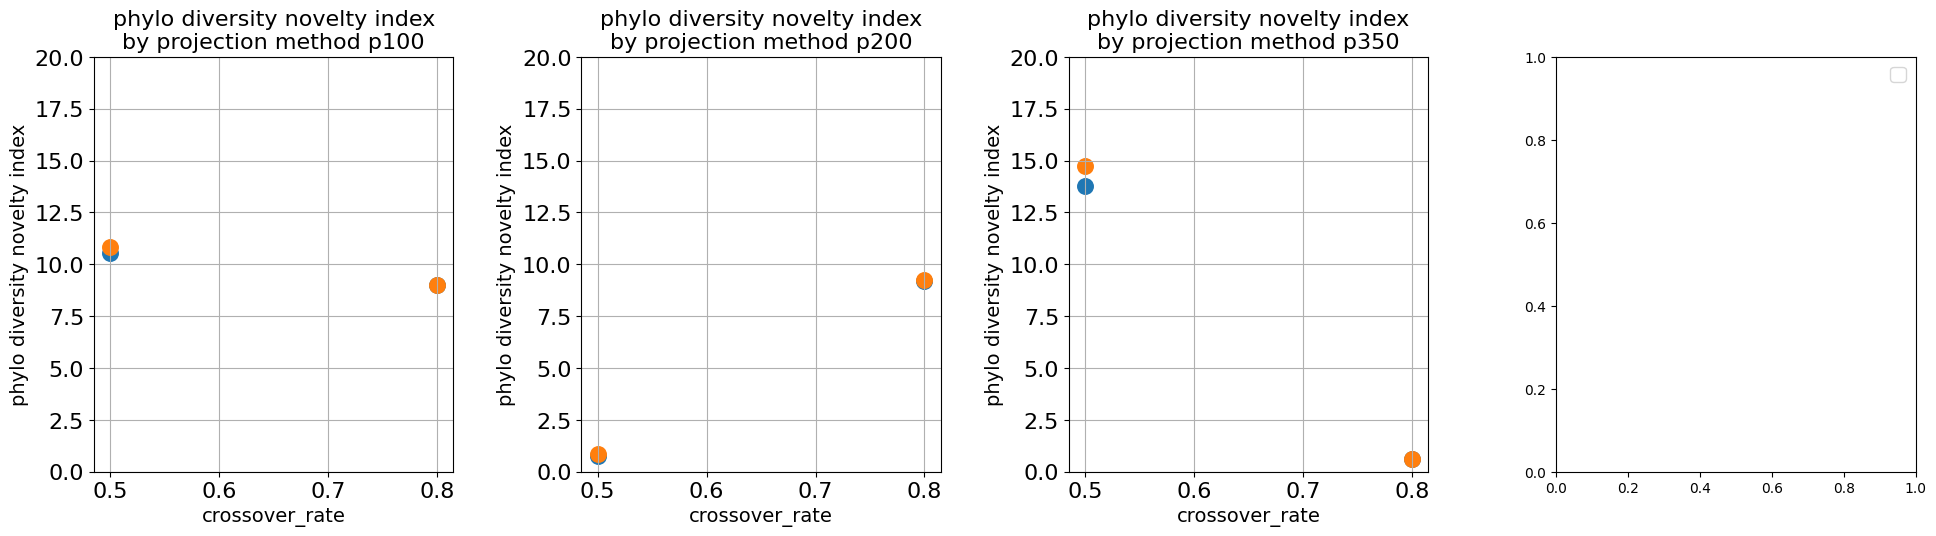

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3825795332.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


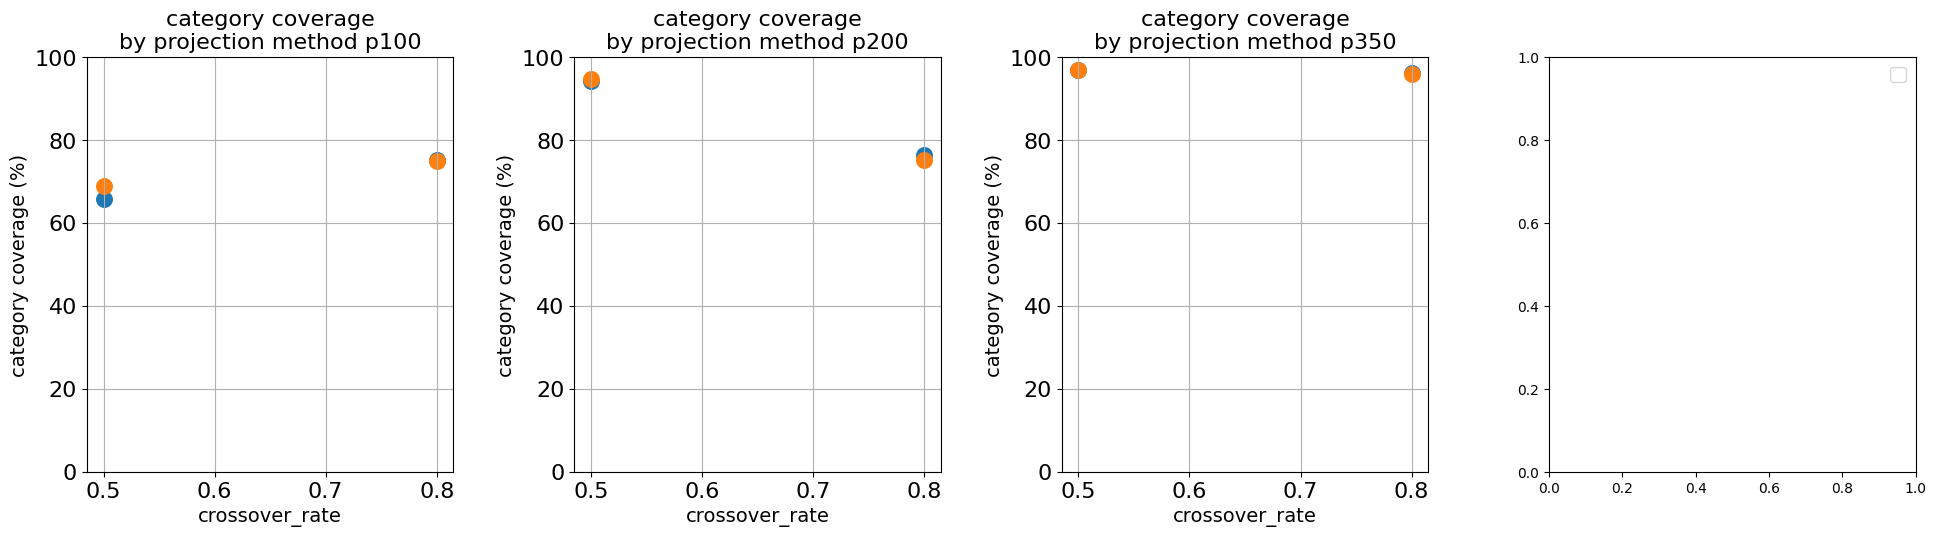

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3825795332.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


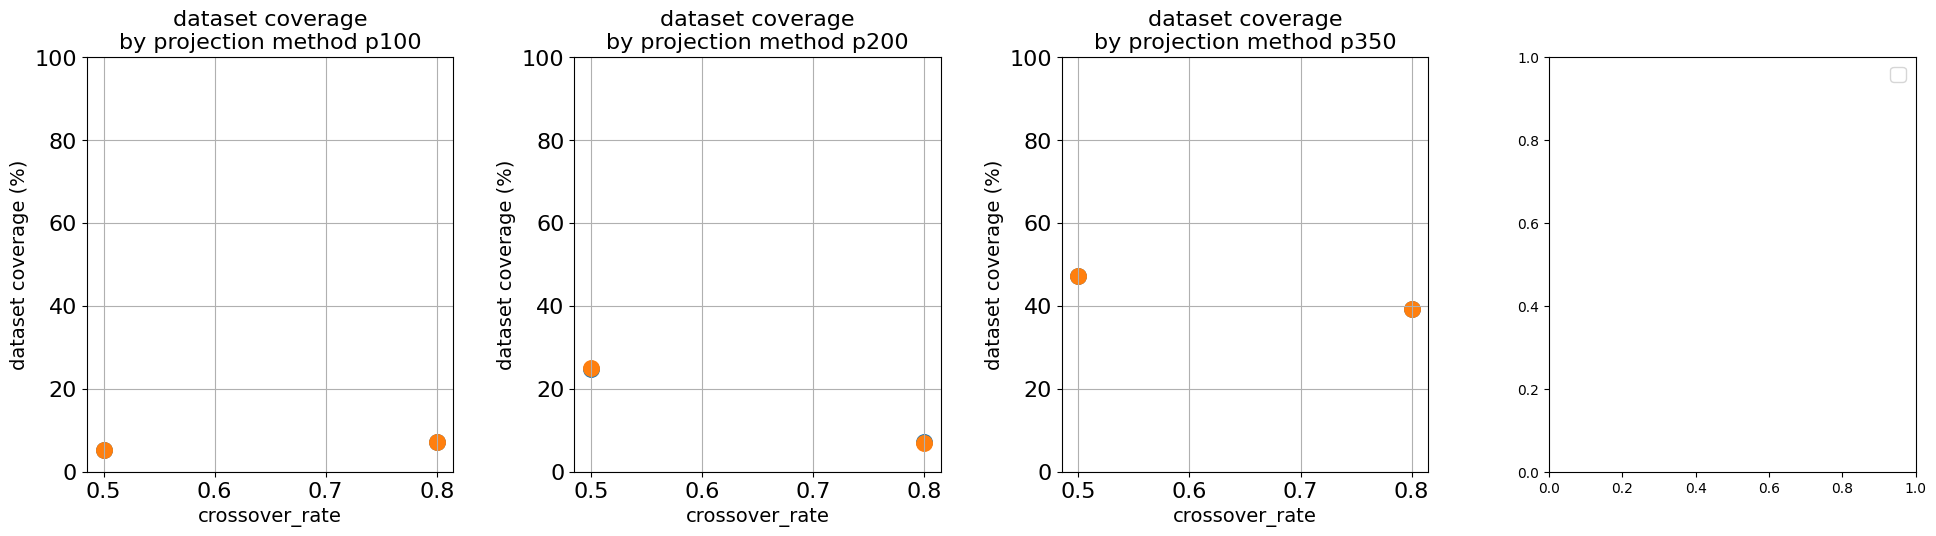

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3825795332.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


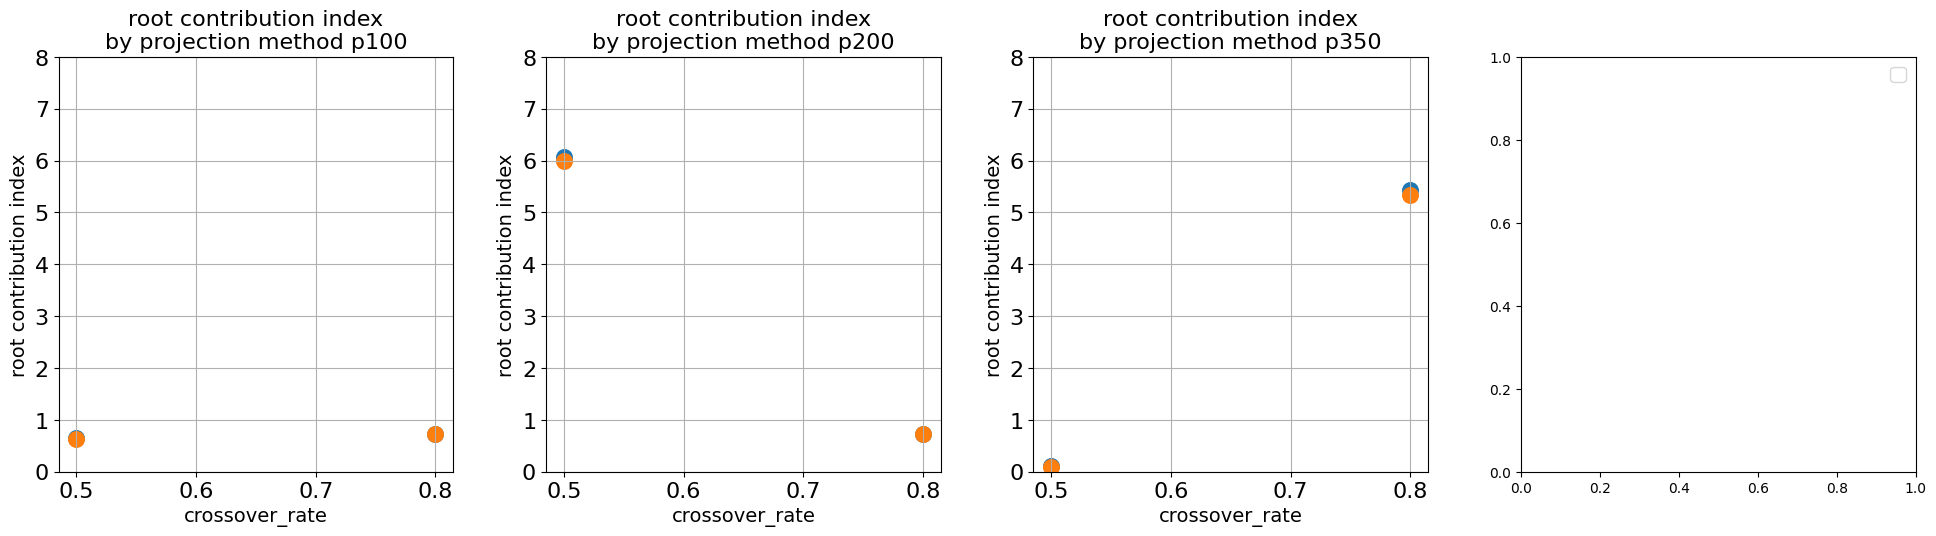

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3825795332.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


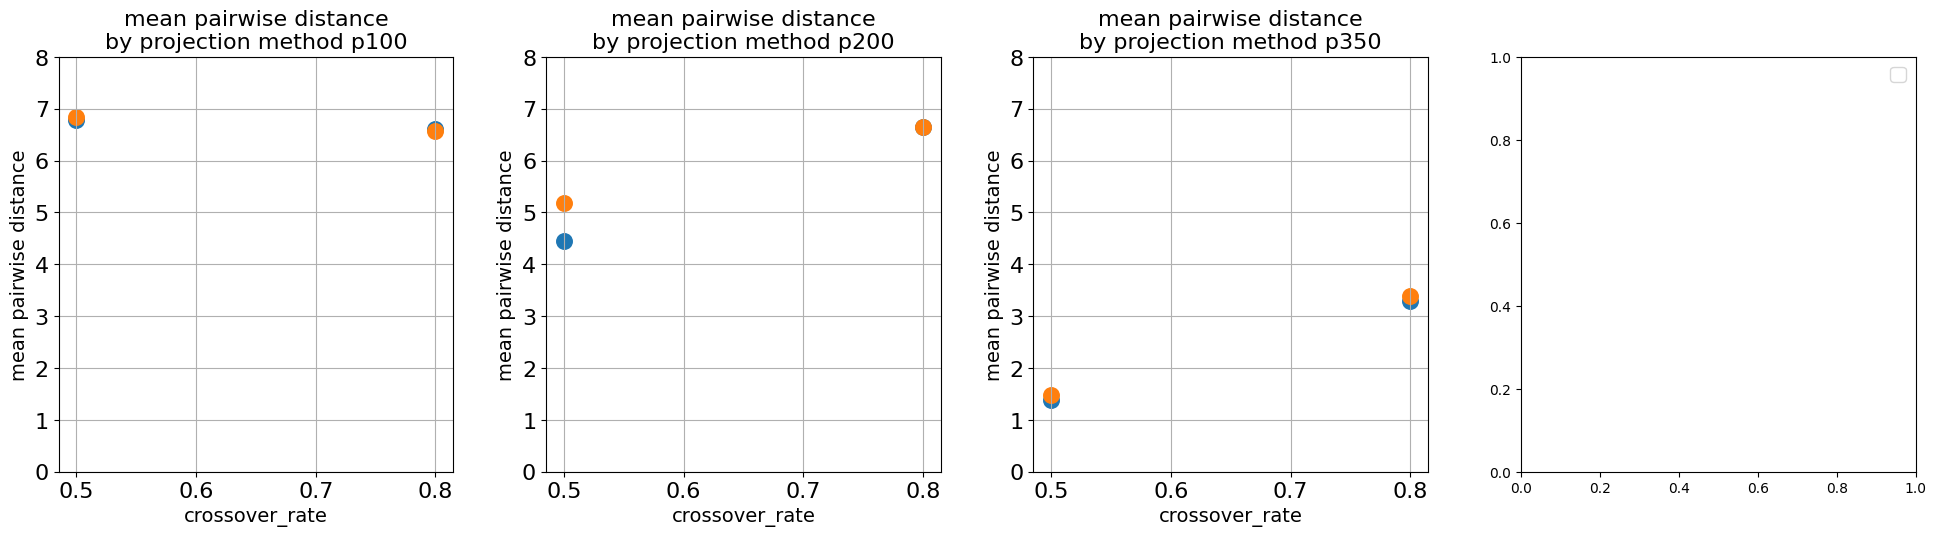

In [8]:
plt.clf()

# plot for each popsize


popsize = 100
popsize = 200
popsize = 350
popsize = 500
popsizes = [100, 200, 350, 500]
popsizes = [100, 200, 350]


# metric


metric = "phylo_diversity_novelty_index"
metric = "category_coverage"
metric = "dataset_coverage"
metric = "category_change_rate"
metric = "functional_variance"
metrics = [
    "phylo_diversity_novelty_index",
    # "categorical_diversity_novelty_index",
    "category_coverage",
    "dataset_coverage",
    # "category_change_rate",
    "root_contribution_index",
    "mean_pairwise_distance",
    # "functional_variance",
]


# crossover rate


target_metric_val = 0.5
target_metric_val = 0.65
target_metric_val = 0.8
corates = [0.5, 0.65, 0.8]
corates = [0.5, 0.8]

# mutation rate
mutation_rate = 0.01
mutation_rate = 0.05
murates = [0.01, 0.05]

metric_lim_map = {
    "phylo_diversity_novelty_index": (0, 20),
    "category_coverage": (0, 100),
    "dataset_coverage": (0, 100),
    "root_contribution_index": (0, 8),
    "mean_pairwise_distance": (0, 8),
}


metric_y_suffix_map = {
    "phylo_diversity_novelty_index": "",
    "category_coverage": " (%)",
    "dataset_coverage": " (%)",
    "root_contribution_index": "",
    "mean_pairwise_distance": "",
}


colors = {"pca": "red", "tsne": "blue", "umap": "green"}

target_metric = "mutation_rate"
target_metric = "crossover_rate"

for metric in metrics:
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    for i, popsize in enumerate(popsizes):

        df_plot_sub = df_plot[
            [
                "phylo_diversity_novelty_index",
                "categorical_diversity_novelty_index",
                "category_change_rate",
                "dataset_coverage",
                "category_coverage",
                "root_contribution_index",
                "mean_pairwise_distance",
                "crossover_rate",
                "mutation_rate",
                "population_size",
                "projection_method",
            ]
        ].copy()

        df_plot_sub = df_plot_sub[df_plot_sub["population_size"] == popsize]
        # df_plot_sub = df_plot_sub[df_plot_sub["projection_method"] == 'tsne']

        # df_plot_sub = df_plot_sub[
        #     df_plot_sub["population_size"].isin([100, 200])
        # ]
        # df_plot_sub = df_plot_sub[df_plot_sub["crossover_rate"] == 0.65]
        # scatter plot x-axis as the crossover rate, y-axis as the metric
        # and color by the projection method
        # fig, ax = plt.subplots(figsize=(6, 4))

        for proj_i, group in df_plot_sub.groupby("projection_method"):

            axs[i].scatter(
                group[target_metric],
                group[metric],
                label=proj_i,
                # alpha=0.75,
                s=125,
                # c=colors[proj_i]
            )

        # axs[i].set_xticks(sorted(df_plot_sub["crossover_rate"].unique()))

        # Ensure the data is sorted by crossover_rate before plotting

        df_plot_sub = df_plot_sub.sort_values(by=target_metric)

        # axs[i].set_xticks(sorted(df_plot_sub["crossover_rate"].unique()))

        # axs[i].set_xticklabels(

        #     [str(x) for x in sorted(df_plot_sub["crossover_rate"].unique())]

        # )

        axs[i].set_xlabel(target_metric, fontsize=14)

        axs[i].set_ylabel(
            metric.replace("_", " ") + metric_y_suffix_map[metric], fontsize=14
        )

        axs[i].set_title(
            f"{metric.replace('_', ' ')}\nby projection method p{popsize}",
            fontsize=16,
        )

        axs[i].set_ylim(*metric_lim_map[metric])

        axs[i].tick_params(axis="both", which="major", labelsize=16)

        axs[i].grid()

    plt.legend(fontsize=14)

    plt.tight_layout(pad=3.0)

    plt.savefig(f"plot_output/{metric}.png")

    plt.show()

### plot array metrics

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


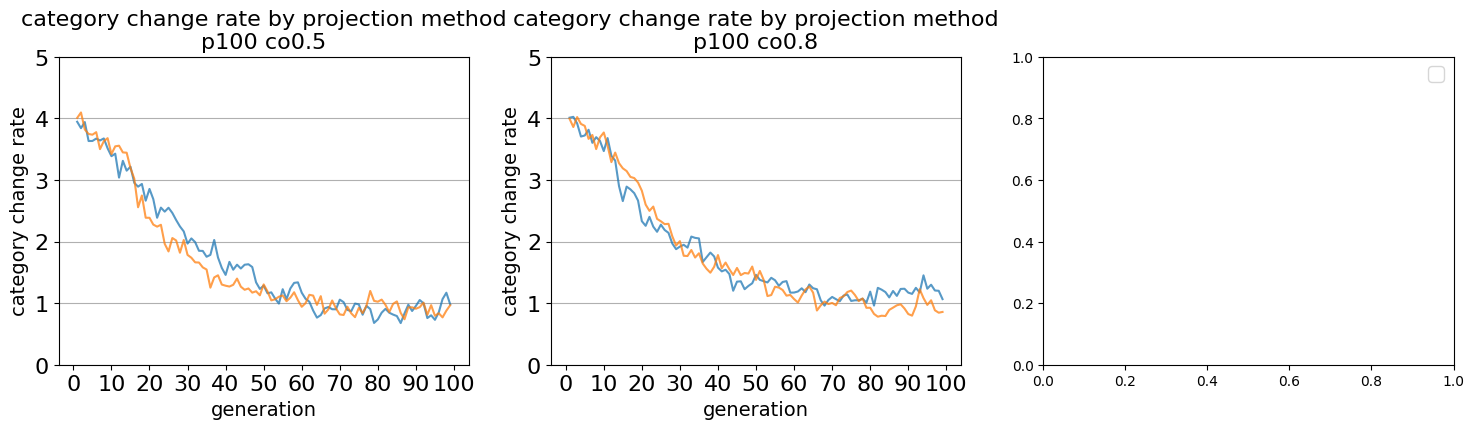

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


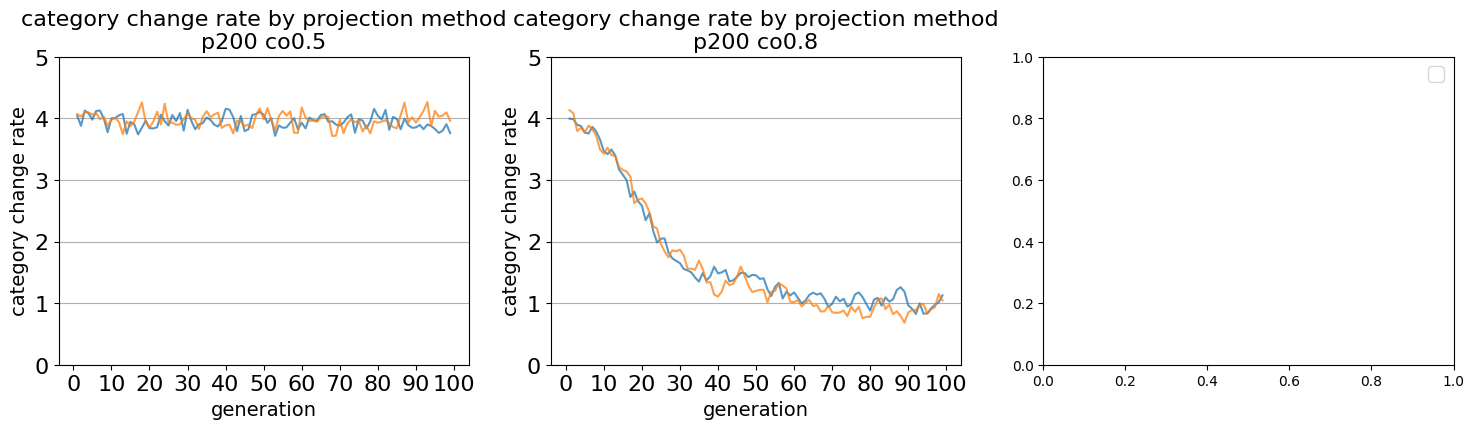

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


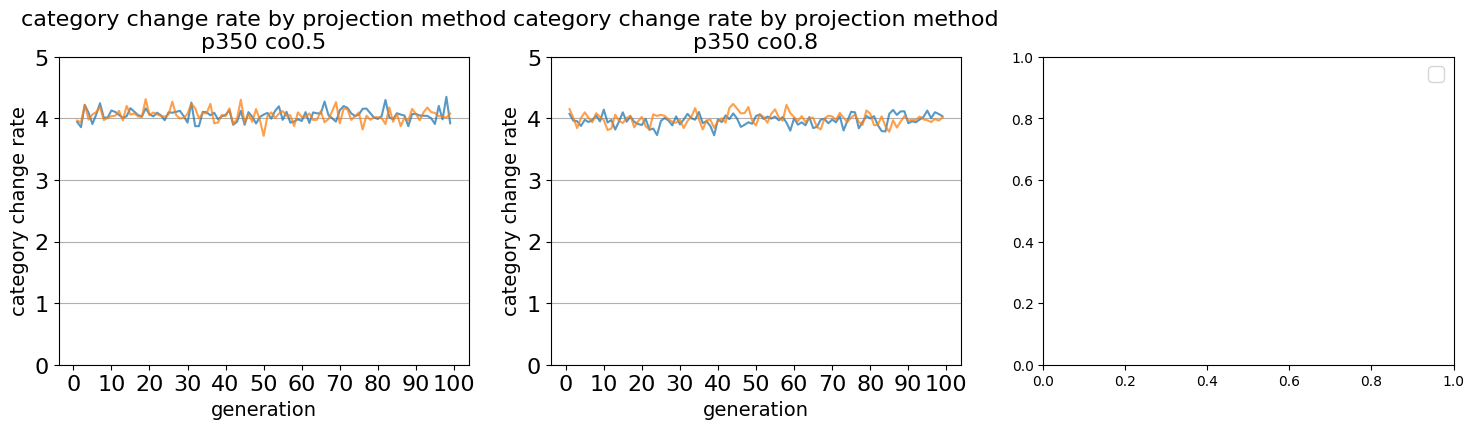

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


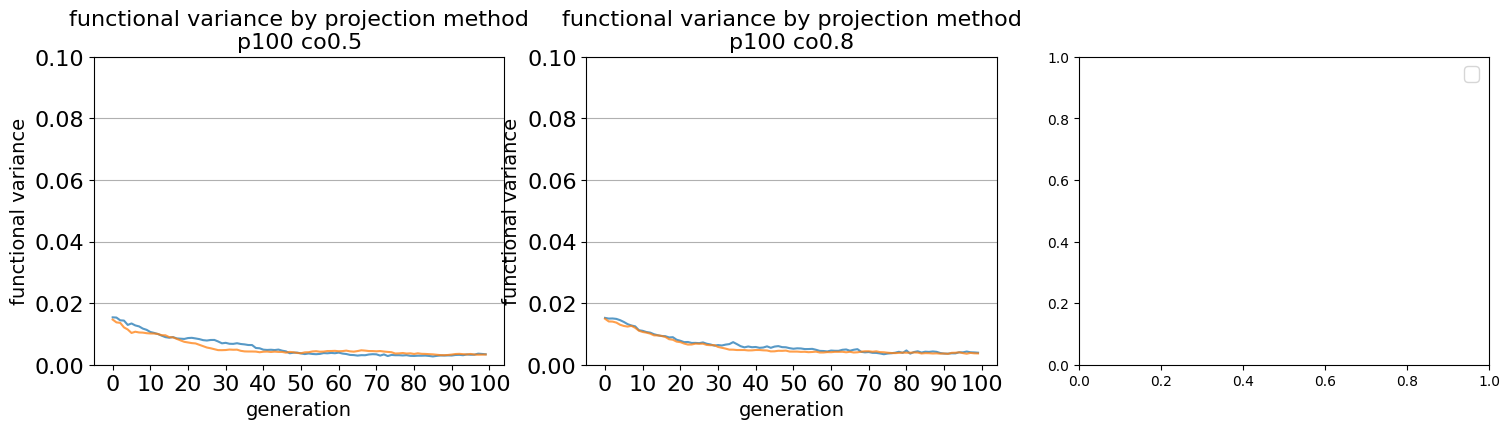

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


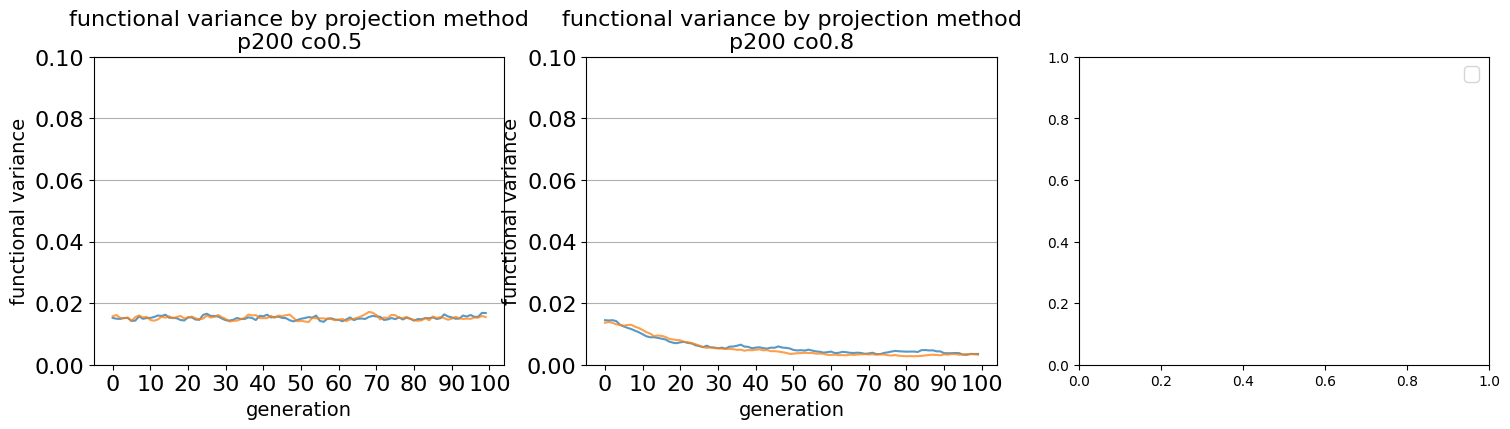

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


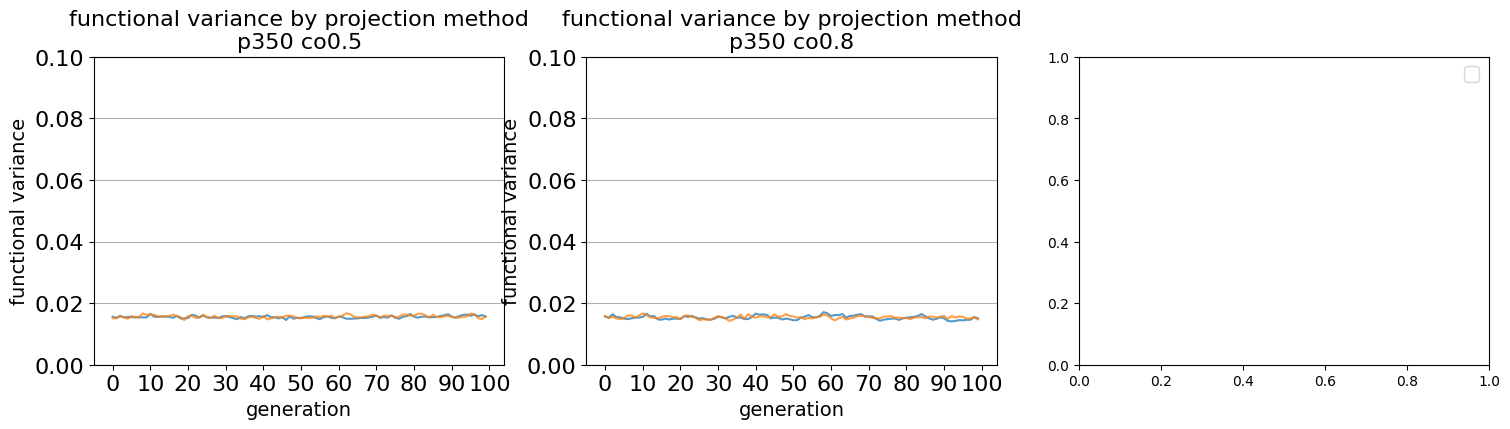

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


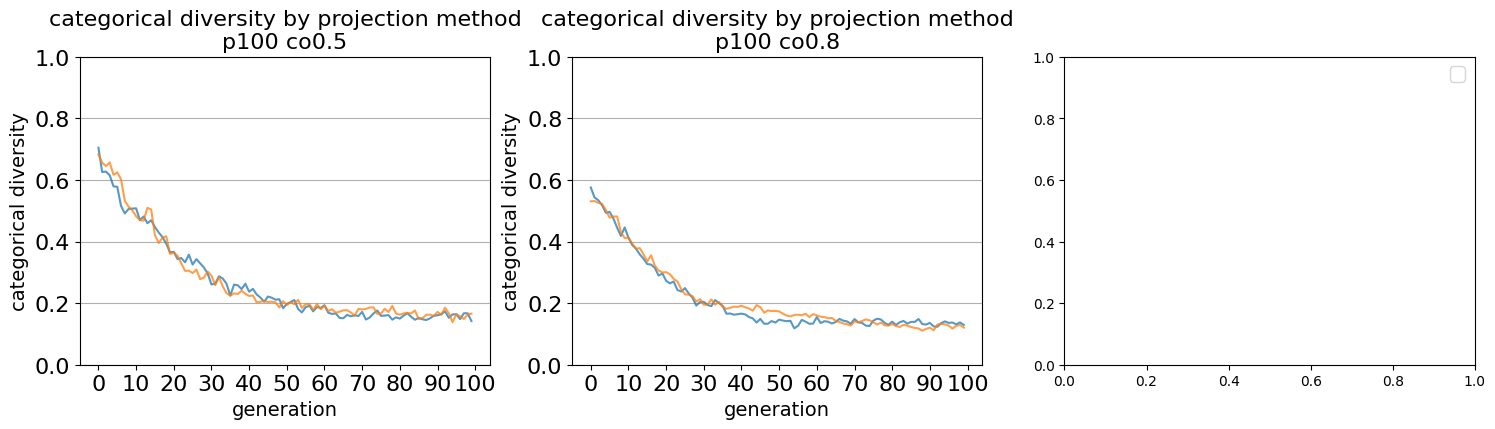

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


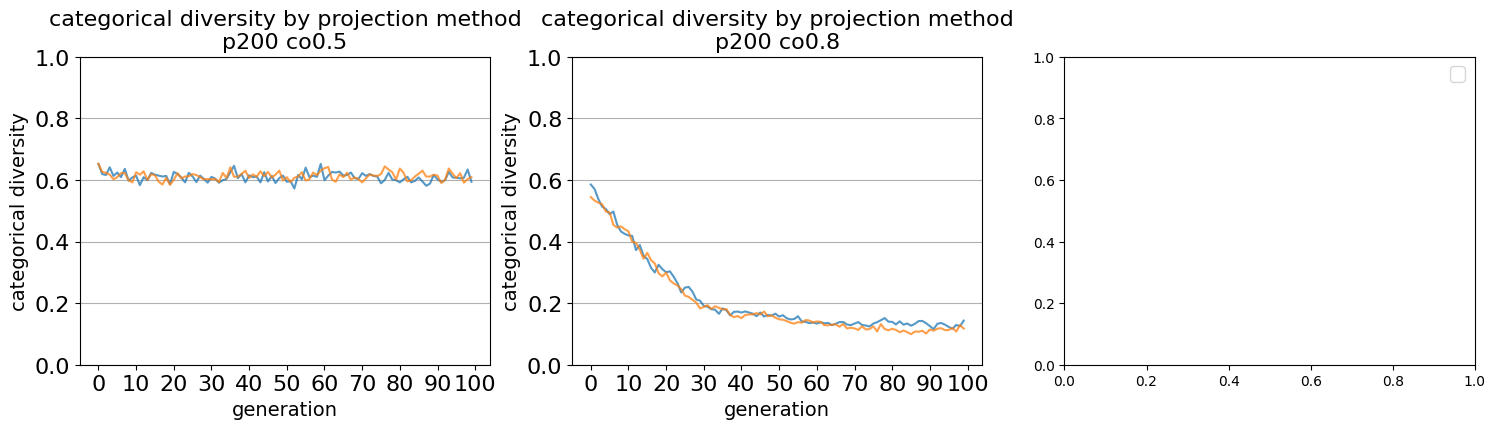

C:\Users\memis\AppData\Local\Temp\ipykernel_24104\3490960390.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


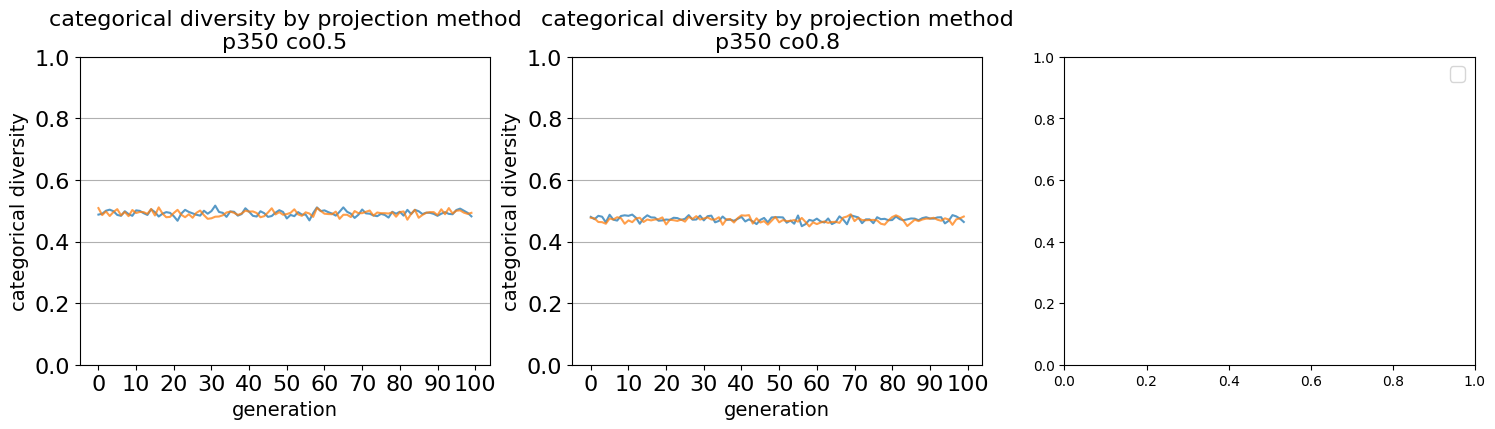

In [9]:
# plot a scatter plot, x axis being the runs, ie index level 1, and y axis
# being the amount. plot projection_method as color

# one plot for each popsize
popsize = 100
popsize = 200
popsize = 350
popsize = 500
popsizes = [100, 200, 350, 500]
popsizes = [100, 200, 350]

# metric
metric = "phylo_diversity_novelty_index"
metric = "category_coverage"
metric = "dataset_coverage"
metric = "category_change_rate"
metric = "functional_variance"
metrics = [
    # "phylo_diversity_novelty_index",
    # "categorical_diversity_novelty_index",
    # "category_coverage",
    # "dataset_coverage",
    "category_change_rate",
    # "root_contribution_index",
    # "mean_pairwise_distance",
    "functional_variance",
    "categorical_diversity",
]
metric_lim_map = {
    "category_coverage": (0, 100),
    "dataset_coverage": (0, 100),
    "category_change_rate": (0, 5),
    "functional_variance": (0, 0.1),
    "categorical_diversity": (0, 1),
}
metric_y_suffix_map = {
    "category_coverage": " (%)",
    "dataset_coverage": " (%)",
    "category_change_rate": "",
    "functional_variance": "",
    "categorical_diversity": "",
}

# crossover rate
target_metric_val = 0.5
target_metric_val = 0.65
target_metric_val = 0.8
corates = [0.5, 0.65, 0.8]
corates = [0.5, 0.8]

# mutation rate
mutation_rate = 0.01
mutation_rate = 0.05
murates = [0.01, 0.05]

colors = {"pca": "red", "tsne": "blue", "umap": "green"}

target_metric = "mutation_rate"
target_metric = "crossover_rate"
target_metric_values = murates
target_metric_values = corates

for metric in metrics:
    for popsize in popsizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        for i, target_metric_val in enumerate(corates):
            df_plot_sub = df_plot[
                [
                    "phylo_diversity_novelty_index",
                    "categorical_diversity_novelty_index",
                    "category_change_rate",
                    "dataset_coverage",
                    "category_coverage",
                    "root_contribution_index",
                    "mean_pairwise_distance",
                    "crossover_rate",
                    "mutation_rate",
                    "population_size",
                    "projection_method",
                    "functional_variance",
                    "categorical_diversity",
                ]
            ].copy()
            df_plot_sub = df_plot_sub[df_plot_sub["population_size"] == popsize]
            df_plot_sub = df_plot_sub[
                df_plot_sub[target_metric] == target_metric_val
            ]

            # fig, ax = plt.subplots(figsize=(6, 4))
            for proj_i, group in df_plot_sub.groupby("projection_method"):
                axs[i].plot(
                    group[metric].iloc[0],
                    label=proj_i,
                    # color=colors[i],
                    alpha=0.75,
                )
            # axs[i].legend()
            axs[i].set_xlabel("generation", fontsize=14)
            axs[i].set_ylabel(
                metric.replace("_", " ") + metric_y_suffix_map[metric],
                fontsize=14,
            )
            axs[i].set_title(
                f"{metric.replace('_', ' ')} by projection method\n"
                f"p{popsize} {'co' if target_metric == 'crossover_rate' else 'mr'}{target_metric_val}",
                fontsize=16,
            )
            axs[i].set_ylim(*metric_lim_map[metric])
            axs[i].set_xticks(np.arange(0, 101, 10))
            axs[i].tick_params(axis="both", which="major", labelsize=16)
            # add horizontal grid
            axs[i].grid(axis="y")
        plt.legend(fontsize=14)
        # plt.tight_layout()
        plt.savefig(f"plot_output/{metric}_p{popsize}.png")
        plt.show()